In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from itertools import product, combinations
from utility import *

def getPossibleStates(edges, max_age):
    """
    Returns: list of states, where each state is a tuple of ((edge), age)
    """
    sorted_edges = sorted(tuple(sorted(e)) for e in edges)
    possible_ages = [-1] + list(range(1, max_age + 1))

    all_states = [
        tuple(zip(sorted_edges, age_combo))
        for age_combo in product(possible_ages, repeat=len(sorted_edges))
    ]

    return all_states

def getAgedStates(state, maxAge):
    """
    Returns:
        New state as a tuple of ((edge), age) pairs
    """
    new_state = []
    for edge, age in state:
        if age == -1:
            new_state.append((edge, -1))  # not entangled
        else:
            new_age = age + 1
            if new_age <= maxAge:
                new_state.append((edge, new_age))
            else:
                new_state.append((edge, -1))  # entanglement expired

    return tuple(sorted(new_state))


def generateAllOutcomes(state, pGen):
    empty_edges = [edge for edge, age in state if age == -1]
    outcomes = []

    for pattern in product([0, 1], repeat=len(empty_edges)):
        prob = 1.0
        new_state = []

        # First, update the empty edges based on entanglement outcomes
        outcome_map = {}
        for (edge, outcome) in zip(empty_edges, pattern):
            if outcome:
                prob *= pGen
                outcome_map[edge] = 1
            else:
                prob *= (1 - pGen)
                outcome_map[edge] = -1

        # Now build the full new state
        for edge, age in state:
            if edge in outcome_map:
                new_state.append((edge, outcome_map[edge]))
            else:
                new_state.append((edge, age))  # unchanged

        outcomes.append((tuple(sorted(new_state)), prob))

    return outcomes

def generateAllSwappingOutcomes(state, goalEdges, pSwap):
    """
    Generate all possible outcomes from swapping operations or doing nothing.
    Can attempt multiple non-overlapping swaps simultaneously.
    """
    def find_path(current, target, visited):
        if current == target:
            return [current]
        visited.add(current)
        for next_node in graph.get(current, []):
            if next_node not in visited:
                path = find_path(next_node, target, visited)
                if path:
                    return [current] + path
        return None

    # First find all possible individual swap attempts
    swap_attempts = []
    entangled_edges = [(edge, age) for edge, age in state if age > 0]
    
    # Create graph once for all path finding
    graph = {}
    for (edge, _) in entangled_edges:
        if edge[0] not in graph: graph[edge[0]] = []
        if edge[1] not in graph: graph[edge[1]] = []
        graph[edge[0]].append(edge[1])
        graph[edge[1]].append(edge[0])
    
    # Find all possible paths for each goal
    for goal_edge in goalEdges:
        start, end = goal_edge
        path = find_path(start, end, set())
        
        if path and len(path) > 1:
            path_edges = list(zip(path[:-1], path[1:]))
            used_edges = []
            for p_edge in path_edges:
                for e, age in entangled_edges:
                    if (e[0] == p_edge[0] and e[1] == p_edge[1]) or \
                       (e[0] == p_edge[1] and e[1] == p_edge[0]):
                        used_edges.append((e, age))
            
            swap_attempts.append({
                'goal': goal_edge,
                'used_edges': used_edges,
                'num_swaps': len(path_edges) - 1
            })
    
    outcomes = []
    
    # Case 1: Do nothing
    outcomes.append((state, 1.0, None))
    
    # Case 2: Try all possible combinations of non-overlapping swaps
    for r in range(1, len(swap_attempts) + 1):
        for attempt_combo in combinations(swap_attempts, r):
            # Check if attempts are compatible (don't share edges)
            all_used_edges = set()
            edge_overlap = False
            for attempt in attempt_combo:
                attempt_edges = set(e for e, _ in attempt['used_edges'])
                if any(e in all_used_edges for e in attempt_edges):
                    edge_overlap = True
                    break
                all_used_edges.update(attempt_edges)
            
            if edge_overlap:
                continue
                
            # Generate all success/failure combinations for this set of attempts
            for success_pattern in product([True, False], repeat=len(attempt_combo)):
                new_state = []
                total_prob = 1.0
                achieved_goals = []
                
                # Calculate probability and track achieved goals
                for attempt, succeeded in zip(attempt_combo, success_pattern):
                    prob = pSwap ** attempt['num_swaps'] if succeeded else \
                          (1 - pSwap ** attempt['num_swaps'])
                    total_prob *= prob
                    if succeeded:
                        achieved_goals.append((attempt['goal'], True))
                    else:
                        achieved_goals.append((attempt['goal'], False))
                
                # Create new state
                for edge, age in state:
                    if any(edge == e for attempt in attempt_combo 
                          for e, _ in attempt['used_edges']):
                        new_state.append((edge, -1))  # Used edges become unentangled
                    else:
                        new_state.append((edge, age))  # Other edges remain unchanged
                
                new_state = tuple(sorted(new_state))
                outcomes.append((new_state, total_prob, achieved_goals))
    
    return outcomes

def getAllTransitionProbabilities(state, goalEdges, pSwap, pGen, maxAge):
    """
    Returns:
        List of (new_state, probability, achieved_goals) tuples
    """
    all_transitions = []
    
    # Get all possible swap action outcomes
    swap_outcomes = generateAllSwappingOutcomes(state, goalEdges, pSwap)
    
    # For each swap outcome, generate all possible generation outcomes
    for swap_state, swap_prob, achieved_goals in swap_outcomes:
        # Skip if swap probability is 0
        if swap_prob == 0:
            continue
            
        # First age the state
        aged_state = getAgedStates(swap_state, maxAge)
        
        # Then get all possible generation outcomes
        gen_outcomes = generateAllOutcomes(aged_state, pGen)
        
        # Combine the probabilities and add to transitions
        for final_state, gen_prob in gen_outcomes:
            # Skip if either probability is 0
            if gen_prob == 0:
                continue
                
            all_transitions.append((
                final_state,
                swap_prob * gen_prob,
                achieved_goals
            ))
    
    return all_transitions

def generateAllStateTransitions(edges, goalEdges, pSwap, pGen, maxAge):
    """
    Returns:
        Dictionary mapping state -> list of (next_state, prob, achieved_goals)
    """
    # Get all possible states
    all_states = getPossibleStates(edges, maxAge)
    transitions = {}
    
    # For each state, calculate all possible transitions
    for state in all_states:
        transitions[state] = getAllTransitionProbabilities(state, goalEdges, pSwap, pGen, maxAge)
    
    return transitions


In [2]:
def getImmediateReward(achieved_goals, goal_success_counts, total_timesteps):
    if achieved_goals is None:
        return 0

    total_reward = 0
    for goal_edge, success in achieved_goals:
        if success:
            start, end = goal_edge
            num_edges = abs(end - start)
            instant_rate = pSwap ** (num_edges - 1)
            edr = goal_success_counts[goal_edge] / max(1, total_timesteps) + 0.001
            if instant_rate > 0 and edr > 0:
                total_reward += instant_rate / edr
    return total_reward


def calculate_fairness_metrics(edrs):
    if not edrs:
        return 0, 0, 0

    values = list(edrs.values())
    numerator = sum(values) ** 2
    denominator = len(values) * sum(x * x for x in values)
    jains_index = numerator / denominator if denominator != 0 else 0
    min_val = min(values)
    max_val = max(values)
    min_max_ratio = min_val / max_val if max_val != 0 else 0
    mean = np.mean(values)
    std = np.std(values)
    cv = std / mean if mean != 0 else 0
    return jains_index, min_max_ratio, cv


class QuantumNetworkQLearning:
    def __init__(self, edges, goalEdges, all_transitions, pSwap, pGen, maxAge, alpha, gamma, epsilon):
        self.edges = edges
        self.goalEdges = goalEdges
        self.all_transitions = all_transitions
        self.pSwap = pSwap
        self.pGen = pGen
        self.maxAge = maxAge

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        self.Q = qTable()

        self.goal_success_counts = {goal: 0 for goal in goalEdges}
        self.edr_history = {goal: [] for goal in goalEdges}
        self.reward_history = []
        self.episode_avg_q_values = []
        self.episode_avg_rewards = []
        self.episode_edrs = {goal: [] for goal in goalEdges}

        self.fairness_history = {
            'jains_index': [],
            'min_max_ratio': [],
            'cv': []
        }

    def group_transitions_by_action(self, state_transitions):
        action_groups = defaultdict(list)
        for next_state, prob, achieved_goals in state_transitions:
            if achieved_goals is None:
                action_key = None
            else:
                action_key = tuple(sorted(goal for goal, _ in achieved_goals))
            action_groups[action_key].append((next_state, prob, achieved_goals))
        return action_groups

    def choose_action(self, state, training=True):
        action_groups = self.group_transitions_by_action(self.all_transitions[state])
        if training and random.random() < self.epsilon:
            chosen_key = random.choice(list(action_groups.keys()))
            transitions = action_groups[chosen_key]
        else:
            best_value = float('-inf')
            best_transitions = None
            for action_key, transitions in action_groups.items():
                q_value = np.mean([
                    self.Q.get_q_value(state, ([], next_state)) for next_state, _, _ in transitions
                ])
                if q_value > best_value:
                    best_value = q_value
                    best_transitions = transitions
            transitions = best_transitions
        probs = [t[1] for t in transitions]
        return random.choices(transitions, weights=probs)[0]

    def train(self, num_episodes=1000, max_steps=100, plot=False):
        window_size = 100
        for episode in range(num_episodes):
            state = tuple((edge, -1) for edge in self.edges)
            episode_reward = 0
            total_timesteps = 1
            episode_q_values = []
            self.goal_success_counts = {goal: 0 for goal in self.goalEdges}
            episode_fairness_values = {'jains_index': [], 'min_max_ratio': [], 'cv': []}

            for step in range(max_steps):
                next_state, prob, achieved_goals = self.choose_action(state, training=True)

                if achieved_goals is not None:
                    for goal_edge, success in achieved_goals:
                        if success:
                            self.goal_success_counts[goal_edge] += 1
                            if episode == num_episodes - 1:
                                 self.edr_history[goal].append(current_edr)  # Keep this


                reward = getImmediateReward(achieved_goals, self.goal_success_counts, total_timesteps)
                episode_reward += reward

                old_q = self.Q.get_q_value(state, ([], next_state))
                next_q = max([
                    self.Q.get_q_value(next_state, ([], ns)) for ns, _, _ in self.all_transitions[next_state]
                ], default=0)
                updated_q = old_q + self.alpha * (reward + self.gamma * next_q - old_q)
                self.Q.set_q_value(state, ([], next_state), updated_q)

                episode_q_values.append(updated_q)

                current_edrs = {goal: self.goal_success_counts[goal] / total_timesteps for goal in self.goalEdges}
                jains, minmax, cv = calculate_fairness_metrics(current_edrs)
                episode_fairness_values['jains_index'].append(jains)
                episode_fairness_values['min_max_ratio'].append(minmax)
                episode_fairness_values['cv'].append(cv)

                for goal in self.goalEdges:
                    current_edr = self.goal_success_counts[goal] / total_timesteps

                state = next_state
                total_timesteps += 1

            self.reward_history.append(episode_reward)
            self.episode_avg_q_values.append(np.mean(episode_q_values))
            for goal in self.goalEdges:
                self.episode_edrs[goal].append(self.goal_success_counts[goal] / total_timesteps)
            self.fairness_history['jains_index'].append(np.mean(episode_fairness_values['jains_index']))
            self.fairness_history['min_max_ratio'].append(np.mean(episode_fairness_values['min_max_ratio']))
            self.fairness_history['cv'].append(np.mean(episode_fairness_values['cv']))

            if len(self.reward_history) >= window_size:
                avg_reward = np.mean(self.reward_history[-window_size:])
                self.episode_avg_rewards.append(avg_reward)

            if (episode + 1) % 100 == 0:
                print('Episode', episode + 1)

        if plot:
            plot_q_learning_results(self)


def plot_q_learning_results(agent):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 18))

    for goal, edr_values in agent.edr_history.items():
        ax1.plot(range(len(edr_values)), edr_values, label=f'Goal {goal}')
    ax1.set_title('EDR Evolution (Last Episode)')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('EDR')
    ax1.grid(True)
    ax1.legend()
    ax1.set_ylim(0, 1)

    ax2.plot(agent.reward_history, alpha=0.3, label='Raw')
    if len(agent.episode_avg_rewards) > 0:
        ax2.plot(range(99, len(agent.episode_avg_rewards) + 99), agent.episode_avg_rewards, label='100-episode moving avg')
    ax2.set_title('Training Progress (Reward)')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Total Reward')
    ax2.grid(True)
    ax2.legend()

    ax3.plot(agent.episode_avg_q_values)
    ax3.set_title('Q-value Convergence')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Q-value')
    ax3.grid(True)

    for goal, edr_values in agent.episode_edrs.items():
        ax4.plot(range(len(edr_values)), edr_values, label=f'Goal {goal}')
    ax4.set_title('EDR Evolution Across Episodes')
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('EDR')
    ax4.grid(True)
    ax4.legend()
    ax4.set_ylim(0, 1)

    ax5.plot(agent.fairness_history['jains_index'], label="Jain's Index")
    ax5.set_title("Jain's Fairness Index Evolution")
    ax5.set_xlabel('Episode')
    ax5.set_ylabel('Fairness Index')
    ax5.grid(True)
    ax5.set_ylim(0, 1)

    ax6.plot(agent.fairness_history['min_max_ratio'], label='Min-Max Ratio')
    ax6.plot(agent.fairness_history['cv'], label='CV')
    ax6.set_title('Fairness Metrics Evolution')
    ax6.set_xlabel('Episode')
    ax6.set_ylabel('Metric Value')
    ax6.grid(True)
    ax6.legend()

    plt.tight_layout()
    plt.show()
# === Q-Learning Wrapper for Experiment Framework ===
def train_q_learning_policy(edges, goal_edges, p_swap, p_gen, max_age, seed=None, **kwargs):
    random.seed(seed)
    np.random.seed(seed)

    all_transitions = generateAllStateTransitions(edges, goal_edges, p_swap, p_gen, max_age)
    agent = QuantumNetworkQLearning(
        edges=edges,
        goalEdges=goal_edges,
        all_transitions=all_transitions,
        pSwap=p_swap,
        pGen=p_gen,
        maxAge=max_age,
        alpha=kwargs.get("alpha", 0.1),
        gamma=kwargs.get("gamma", 0.99),
        epsilon=kwargs.get("epsilon", 0.001)
    )
    agent.train(num_episodes=kwargs.get("num_episodes", 5), max_steps=kwargs.get("max_steps", 1000), plot=False)
    return agent.Q

# # === CONFIGURATION ===
# edges = [(0, 1), (1, 2), (2, 3), (3, 4)]
# goalEdges = [(0, 4), (2, 4)]
# pSwap = 0.8
# pGen = 0.8
# maxAge = 2
# gamma = 0.99
# epsilon = 0.001
# alpha = 0.1
# epsiodes = 10
# maxSteps= 5000
# print('training')
# # === Run Q-Learning Experiments with Unified Framework ===
# ql_results = run_policy_experiments(
#     train_policy_fn=train_q_learning_policy,
#     policy_name="Q-Learning",
#     edges=edges,
#     goal_edges=goalEdges,
#     p_swap=pSwap,
#     p_gen=pGen,
#     max_age=maxAge,
#     num_runs=5,
#     num_steps=10000,
#     num_simulations=5,
#     train_kwargs={
#         "alpha": alpha,
#         "gamma": gamma,
#         "epsilon": epsilon,
#         "num_episodes": epsiodes,
#         "max_steps": maxSteps
#     },
#     plot=True
# )


training

=== Q-Learning Policy Training Run 1 ===

=== Q-Learning Policy Training Run 2 ===

=== Q-Learning Policy Training Run 3 ===

=== Q-Learning Policy Training Run 4 ===

=== Q-Learning Policy Training Run 5 ===
PLOTTING


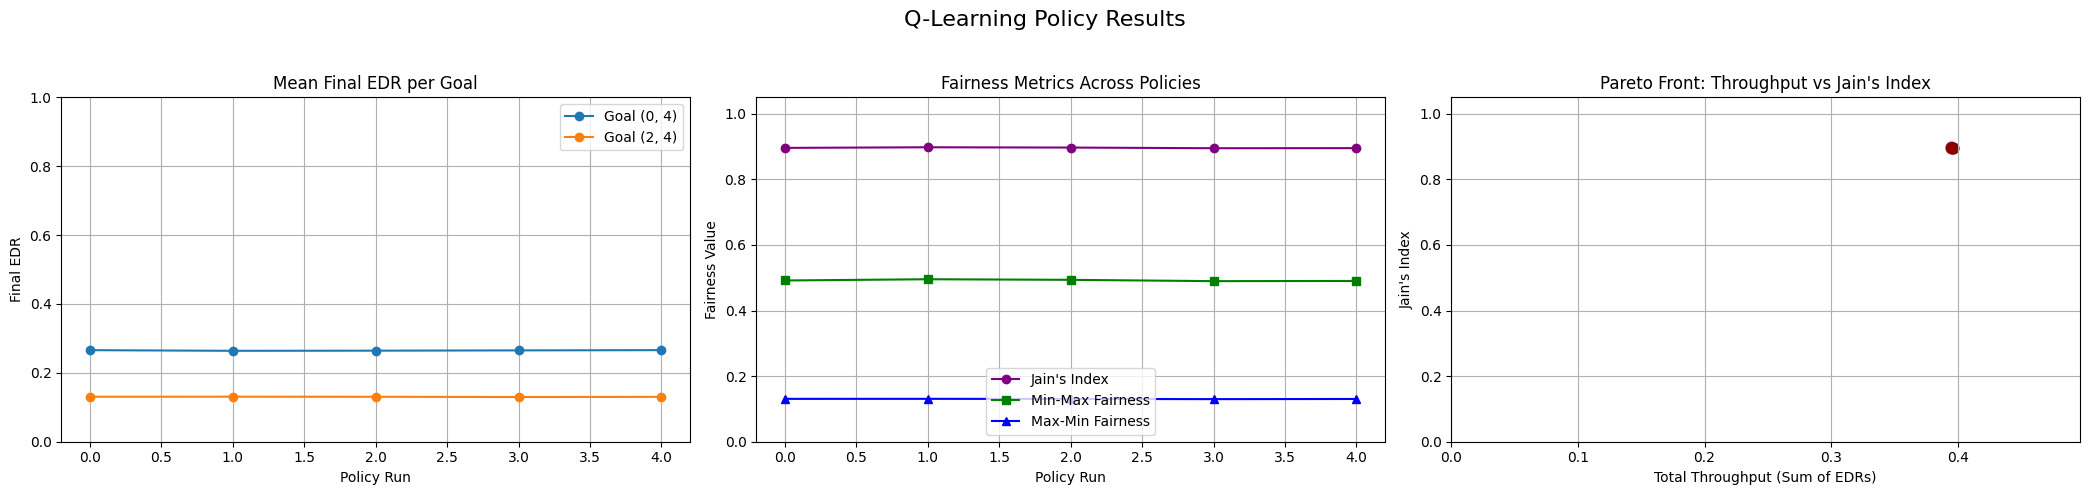

training

=== Q-Learning Policy Training Run 1 ===

=== Q-Learning Policy Training Run 2 ===

=== Q-Learning Policy Training Run 3 ===

=== Q-Learning Policy Training Run 4 ===

=== Q-Learning Policy Training Run 5 ===
PLOTTING


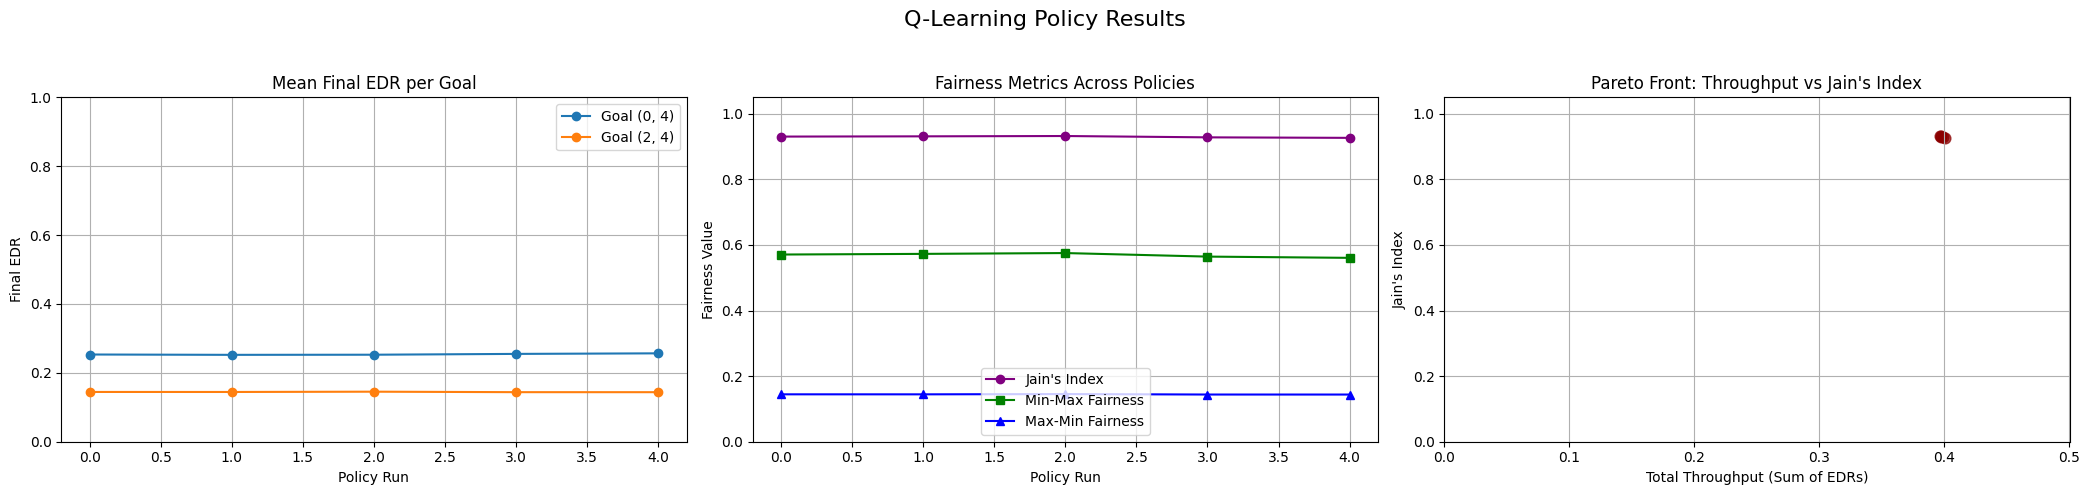

In [3]:
# === CONFIGURATION ===
edges = [(0, 1), (1, 2), (2, 3), (3, 4)]
goalEdges = [(0, 4), (2, 4)]
pSwap = 0.8
pGen = 0.8
maxAge = 3
gamma = 0.99
epsilon = 0.001
alpha = 0.1
epsiodes = 10
maxSteps= 5000
print('training')
# === Run Q-Learning Experiments with Unified Framework ===
ql_results = run_policy_experiments(
    train_policy_fn=train_q_learning_policy,
    policy_name="Q-Learning",
    edges=edges,
    goal_edges=goalEdges,
    p_swap=pSwap,
    p_gen=pGen,
    max_age=maxAge,
    num_runs=5,
    num_steps=10000,
    num_simulations=5,
    train_kwargs={
        "alpha": alpha,
        "gamma": gamma,
        "epsilon": epsilon,
        "num_episodes": epsiodes,
        "max_steps": maxSteps
    },
    plot=True
)# === CONFIGURATION ===
edges = [(0, 1), (1, 2), (2, 3), (3, 4)]
goalEdges = [(0, 4), (2, 4)]
pSwap = 0.8
pGen = 0.8
maxAge = 2
gamma = 0.98
epsilon = 0.001
alpha = 0.2
epsiodes = 10
maxSteps= 5000
print('training')
# === Run Q-Learning Experiments with Unified Framework ===
ql_results = run_policy_experiments(
    train_policy_fn=train_q_learning_policy,
    policy_name="Q-Learning",
    edges=edges,
    goal_edges=goalEdges,
    p_swap=pSwap,
    p_gen=pGen,
    max_age=maxAge,
    num_runs=5,
    num_steps=10000,
    num_simulations=5,
    train_kwargs={
        "alpha": alpha,
        "gamma": gamma,
        "epsilon": epsilon,
        "num_episodes": epsiodes,
        "max_steps": maxSteps
    },
    plot=True
)

In [ ]:
edges = [(0, 1), (1, 2), (2, 3), (3, 4)]
goalEdges = [(0, 4), (2, 4)]
pSwap = 0.8
pGen = 0.8
maxAge = 2
gamma = 0.98
epsilon = 0.001
alpha = 0.1
episodes = 10
maxSteps= 6000 # training

compare_policies_across_param(
    policy_name="Q-Learning",
    policy_train_fn=train_q_learning_policy,
    param_name="pGen",
    param_values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    edges=[(0, 1), (1, 2), (2, 3), (3, 4)],
    goal_edges=[(0, 4), (2, 4)],
    p_gen=0.8,  # default, will get overridden per iteration
    p_swap=0.8,
    max_age=2,
    train_kwargs={"alpha": 0.1, "gamma": 0.98, "epsilon": 0.001, "num_episodes": 10, "max_steps": 6000},
    plot=True,
    num_runs=5,
    num_steps=5000,
    num_simulations=3
)

compare_policies_across_param(
    policy_name="Q-Learning",
    policy_train_fn=train_q_learning_policy,
    param_name="pSwap",
    param_values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    edges=[(0, 1), (1, 2), (2, 3), (3, 4)],
    goal_edges=[(0, 4), (2, 4)],
    p_gen=0.8,
    p_swap=0.8,  # default, will get overridden per iteration
    max_age=2,
    train_kwargs={"alpha": 0.1, "gamma": 0.98, "epsilon": 0.001, "num_episodes": 10, "max_steps": 6000},
    plot=True,
    num_runs=5,
    num_steps=5000,
    num_simulations=3
)


=== Evaluating Q-Learning for pGen = 0.1 ===

=== Q-Learning (pGen=0.1) Policy Training Run 1 ===

=== Q-Learning (pGen=0.1) Policy Training Run 2 ===

=== Q-Learning (pGen=0.1) Policy Training Run 3 ===
